In [ ]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import os
from torchvision import datasets, transforms
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import time as t
import seaborn as sns
from sklearn.metrics import confusion_matrix
from torch.cuda import amp
import pandas as pd
import tqdm
plt.style.use('bmh')
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
from torchsummary import summary
torch.backends.cudnn.deterministic = True
np.random.seed(4000)
torch.manual_seed(4000)

# Dataset

## class

In [2]:
Mnist_classes = ('0', '1', '2', '3',
           '4', '5', '6', '7', '8', '9')
KMnist_classes = ('お', 'き', 'す', 'つ',
           'な', 'は', 'ま', 'や', 'れ', 'を')
flower_calsses = [
    "pink primrose", "hard-leaved pocket orchid", "canterbury bells",
    "sweet pea", "english marigold", "tiger lily", "moon orchid",
    "bird of paradise", "monkshood", "globe thistle", "snapdragon",
    "colt's foot", "king protea", "spear thistle", "yellow iris",
    "globe-flower", "purple coneflower", "peruvian lily", "balloon flower",
    "giant white arum lily", "fire lily", "pincushion flower", "fritillary",
    "red ginger", "grape hyacinth", "corn poppy", "prince of wales feathers",
    "stemless gentian", "artichoke", "sweet william", "carnation",
    "garden phlox", "love in the mist", "mexican aster", "alpine sea holly",
    "ruby-lipped cattleya", "cape flower", "great masterwort", "siam tulip",
    "lenten rose", "barbeton daisy", "daffodil", "sword lily", "poinsettia",
    "bolero deep blue", "wallflower", "marigold", "buttercup", "oxeye daisy",
    "common dandelion", "petunia", "wild pansy", "primula", "sunflower",
    "pelargonium", "bishop of llandaff", "gaura", "geranium", "orange dahlia",
    "pink-yellow dahlia?", "cautleya spicata", "japanese anemone",
    "black-eyed susan", "silverbush", "californian poppy", "osteospermum",
    "spring crocus", "bearded iris", "windflower", "tree poppy", "gazania",
    "azalea", "water lily", "rose", "thorn apple", "morning glory",
    "passion flower", "lotus", "toad lily", "anthurium", "frangipani",
    "clematis", "hibiscus", "columbine", "desert-rose", "tree mallow",
    "magnolia", "cyclamen", "watercress", "canna lily", "hippeastrum",
    "bee balm", "ball moss", "foxglove", "bougainvillea", "camellia", "mallow",
    "mexican petunia", "bromelia", "blanket flower", "trumpet creeper",
    "blackberry lily"
]

## load & show Data 

In [3]:
def choise_transform(mode, epoch=-1):
    rgb_mode = transforms.Compose([transforms.ToTensor(),
                                   transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
                                   transforms.CenterCrop(400),
                                   transforms.Resize(200)
                                   ])
    gray_mode = transforms.Compose([transforms.ToTensor(),
                                      transforms.Normalize((0.5), (0.5))])


    if epoch<0:
        if mode == 'gray_normal':
            return gray_mode
        if mode == 'RGB_normal':
            return rgb_mode


    elif epoch<30:
        randlist = []
        for i in range(6):
            if np.random.rand(1)<0.6:
                randlist.append(i)

        return add_transform([0,1,2,3,4])
    elif epoch<40:
        randlist = []
        for i in range(5):
            if np.random.rand(1)<0.6:
                randlist.append(i)
        return add_transform([0,1,2,3])
    elif epoch<45:
        return add_transform([0,1,2])
    elif epoch<47:
        return None
    # else:
    #     return None
    # transforms.Resize((200, 200))

In [ ]:
def add_transform(translist=[]):
    transformsList = [transforms.RandomRotation(45,center=None),
                      transforms.RandomHorizontalFlip(p=0.5),
                      transforms.RandomVerticalFlip(p=0.5),
                      transforms.RandomResizedCrop(size=200, scale=(0.5, 2)),
                      transforms.RandomAffine(degrees=0, shear=(0, 0, 0, 45)),
                      transforms.ColorJitter(hue=0.1),
                      ]

    new_transform = [transforms.ToTensor(),
                     ]
    for i in translist:
        new_transform.append(transformsList[i])
    return transforms.Compose(new_transform)

In [4]:

# Mnist dataset
transform = choise_transform('gray_normal')
Mnist_trainSet = datasets.MNIST(root='./data', download=True, train=True, transform=transform)
Mnist_testSet = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

#KMnist dataset
KMnist_trainSet = datasets.KMNIST(root='./data', download=True, train=True, transform=transform)
KMnist_testSet = datasets.KMNIST(root='./data', train=False, download=True, transform=transform)

#Flowers102 dataset
transform = choise_transform('RGB_normal')
flower_trainSet = datasets.Flowers102(root='./data', download=True, split = 'test', transform=transform)
flower_testSet = datasets.Flowers102(root='./data', split = 'train', download=True, transform=transform)




In [5]:
if flower_trainSet[0][1] == 1:
    minus1 = True
print(minus1)

True


In [7]:
Mnist_trainloader = torch.utils.data.DataLoader(Mnist_trainSet, batch_size=64,
                                          shuffle=True, num_workers=4)
Mnist_testloader = torch.utils.data.DataLoader(Mnist_testSet, batch_size=64,
                                          shuffle=False, num_workers=4)

KMnist_trainloader = torch.utils.data.DataLoader(KMnist_trainSet, batch_size=64,
                                          shuffle=True, num_workers=4)
KMnist_testloader = torch.utils.data.DataLoader(KMnist_testSet, batch_size=64,
                                          shuffle=False, num_workers=4)

flower_trainloader = torch.utils.data.DataLoader(flower_trainSet, batch_size=64,
                                          shuffle=True, num_workers=4)
flower_testloader = torch.utils.data.DataLoader(flower_testSet, batch_size=64,
                                          shuffle=False, num_workers=4)


In [8]:
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

## show data

tensor([25, 34, 78, 56, 77, 82, 88, 87, 59, 95, 38, 46, 30, 90, 74, 75, 55, 75,
        80, 77, 84,  8, 22, 58, 54, 83, 73, 78, 76, 94, 11, 77, 88, 56, 73, 94,
        74, 36, 89, 30, 83, 36, 22, 51, 94, 17, 46, 51, 47, 88, 91, 51, 76, 23,
        84, 46, 80, 74, 78, 36,  5, 72, 64, 10])
corn poppy alpine sea holly toad lily gaura lotus


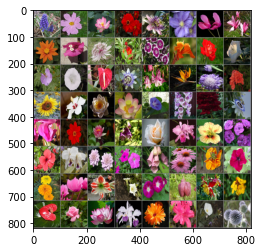

In [9]:
dataiter = iter(flower_trainloader)
images, labels = dataiter.next()
# show images

#show(torchvision.utils.make_grid([images[0],images[1]]))
imshow(torchvision.utils.make_grid([images[0],images[1], images[2]], padding=3))
# print labels
print(' '.join('%5s' % flower_calsses[labels[j]] for j in range(5)))

    9     8     4     0     9


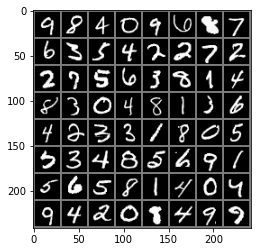

In [10]:
# get some random training images
dataiter = iter(Mnist_trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % Mnist_classes[labels[j]] for j in range(5)))

    す     を     つ     れ     つ


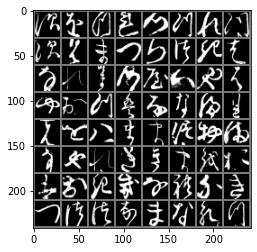

In [11]:
# get some random training images
dataiter = iter(KMnist_testloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % KMnist_classes[labels[j]] for j in range(5)))

# Model

In [9]:
torch.cuda.set_device(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device", torch.cuda.current_device(), torch.cuda.get_device_name(torch.cuda.current_device()))

device 0 NVIDIA GeForce RTX 2080 with Max-Q Design


In [10]:
class PrintLayer(nn.Module):
    def __init__(self):
        super(PrintLayer, self).__init__()
    
    def forward(self, x):
        # Do your print / debug stuff here
        print(x.shape)
        return x

In [11]:
class my_mnist_Net(nn.Module):
    
        
    def __init__(self, activate_F):
        super(my_mnist_Net, self).__init__()
        self.activate_F = activate_F
        printL = PrintLayer()
        
        # input : 3 X 28 X 28
        
        #(width + pad*2 - kernel)/stride + 1

        
        self.main = nn.Sequential(
            nn.Conv2d(1, 16, 3, 1, 1, bias=False),
            nn.BatchNorm2d(16),
            self.choise_activate(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.3),
            #printL,
            
            nn.Conv2d(16, 64, 3, 1, 1, bias=False),
            nn.BatchNorm2d(64),
            self.choise_activate(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.3),

            
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, 128),
            nn.Linear(128, 10),
        )
    
    def choise_activate(self):
        if self.activate_F == 'relu':
            return nn.ReLU()
        elif self.activate_F == 'leaky_r':
            return nn.LeakyReLU()
        elif self.activate_F == 'elu':
            return nn.ELU()
    def forward(self, input):
        return self.main(input)

In [15]:
net = my_mnist_Net('elu').to(device)
summary(net, (1, 28, 28))

KeyboardInterrupt: 

In [12]:
class flower_Net(nn.Module):
    def __init__(self, activate_F):
        super(flower_Net, self).__init__()
        # input : 3 X 32 X 32
        self.activate_F = activate_F
        printL = PrintLayer()
        
        #(width + pad*2 - kernel)/stride + 1
        
        self.main = nn.Sequential(
            nn.Conv2d(3, 128, 3, 1, 1, bias=False),
            nn.BatchNorm2d(128),
            self.activate_F,
            nn.MaxPool2d(2, 2),
            
            
            nn.Conv2d(128, 256, 3, 1, 1, bias=False),
            nn.BatchNorm2d(256),
            self.activate_F,
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.3),
            
            nn.Conv2d(256, 512, 3, 1, 1, bias=False),
            nn.BatchNorm2d(512),
            self.activate_F,
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.3),
            
            nn.Conv2d(512, 512, 3, 1, 1, bias=False),
            nn.BatchNorm2d(512),
            self.activate_F,
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.3),
            
            nn.Conv2d(512, 256, 3, 1, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            #printL,
            
            nn.Flatten(),
            nn.Linear(256 * 6 * 6, 512),
            nn.Linear(512, 256),
            nn.Linear(256, 102),
        )
        
    def choise_activate(self):
        if self.activate_F == 'relu':
            return nn.ReLU()
        elif self.activate_F == 'leaky_r':
            return nn.LeakyReLU()
        elif self.activate_F == 'elu':
            return nn.ELU()

    def forward(self, input):
        return self.main(input)

In [22]:
net = flower_Net('relu').to(device)
summary(net, (3, 100, 100))

torch.Size([2, 256, 3, 3])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1        [-1, 128, 100, 100]           3,456
       BatchNorm2d-2        [-1, 128, 100, 100]             256
         LeakyReLU-3        [-1, 128, 100, 100]               0
         MaxPool2d-4          [-1, 128, 50, 50]               0
           Dropout-5          [-1, 128, 50, 50]               0
            Conv2d-6          [-1, 256, 50, 50]         294,912
       BatchNorm2d-7          [-1, 256, 50, 50]             512
         LeakyReLU-8          [-1, 256, 50, 50]               0
         MaxPool2d-9          [-1, 256, 25, 25]               0
          Dropout-10          [-1, 256, 25, 25]               0
           Conv2d-11          [-1, 512, 25, 25]       1,179,648
      BatchNorm2d-12          [-1, 512, 25, 25]           1,024
        LeakyReLU-13          [-1, 512, 25, 25]               0
        MaxP

In [15]:
# class flower_Net(nn.Module):
    
        
#     def __init__(self, activate_F):
#         super(flower_Net, self).__init__()
#         self.activate_F = activate_F
#         printL = PrintLayer()
        
#         # input : 3 X 28 X 28
        
#         #(width + pad*2 - kernel)/stride + 1

        
#         self.main = nn.Sequential(
#             nn.Conv2d(3, 16, 3, 1, 1, bias=False),
#             nn.BatchNorm2d(16),
#             self.choise_activate(),
#             nn.MaxPool2d(2, 2),
#             nn.Dropout(0.3),
            
            
#             nn.Conv2d(16, 64, 3, 1, 1, bias=False),
#             nn.BatchNorm2d(64),
#             self.choise_activate(),
#             nn.MaxPool2d(2, 2),
#             nn.Dropout(0.3),
#             #printL,
            
#             nn.Flatten(),
#             nn.Linear(64 * 50 * 50, 512),
#             nn.Linear(512, 102),
#         )
    
#     def choise_activate(self):
#         if self.activate_F == 'relu':
#             return nn.ReLU()
#         elif self.activate_F == 'leaky_r':
#             return nn.LeakyReLU()
#         elif self.activate_F == 'elu':
#             return nn.ELU()
#     def forward(self, input):
#         return self.main(input)

In [48]:
# net = flower_Net('relu').to(device)
# summary(net, (3, 100, 100))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 100, 100]             432
       BatchNorm2d-2         [-1, 16, 100, 100]              32
              ReLU-3         [-1, 16, 100, 100]               0
         MaxPool2d-4           [-1, 16, 50, 50]               0
           Dropout-5           [-1, 16, 50, 50]               0
            Conv2d-6           [-1, 64, 50, 50]           9,216
       BatchNorm2d-7           [-1, 64, 50, 50]             128
              ReLU-8           [-1, 64, 50, 50]               0
         MaxPool2d-9           [-1, 64, 25, 25]               0
          Dropout-10           [-1, 64, 25, 25]               0
          Flatten-11                [-1, 40000]               0
           Linear-12                  [-1, 512]      20,480,512
           Linear-13                  [-1, 102]          52,326
Total params: 20,542,646
Trainable para

In [14]:
def choise_net(my_Net):
    return my_Net().to(device)

In [15]:
def plot_loss(loss):
    plt.figure(figsize=(10,5))
    plt.title("loss")
    plt.plot(loss,label="Loss")
    plt.xlabel("iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

## define Train phase, Test phase

In [16]:
def train_part(net, trainloader, testloader, criterion, optimizer, epochs, add_data=False):
    total_t = 0
    # writer = SummaryWriter(log_dir)
    iters = 0
    losses = []
    scaler = amp.GradScaler()
    for epoch in range(epochs):  # loop over the dataset multiple times
        
        start_time = t.time()
        mean_loss = 0.0
        batch_loss = 0
        for i, data in enumerate(trainloader, 0):

            net.train()    

            # get the inputs
            inputs, labels = data[0], data[1].to(device)
            if minus1:
                labels -= 1

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            inputs_cp = inputs.detach().clone()
            # if add_data:
            #     for idx in range(len(labels)):
            #         inputs_cp[idx] = training_transform(inputs_cp[idx].permute(1, 2, 0).numpy())
            
            
            with amp.autocast():
                outputs = net(inputs_cp.to(device))
                loss = criterion(outputs, labels)
            
            
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad(set_to_none=True)

            # print statistics
            if i == 0:
                print(f"\nEpoch:{epoch+1}")
            mean_loss += loss.item()
            
            print(f"\r\tBatch:{i+1:03} of {len(trainloader)}, loss:{loss.item():.3f}, MeanLoss:{mean_loss/(i+1):.3f}", end='')
            # batch_szie = labels.size(0)
            # batch_loss += loss.item()
            losses.append(mean_loss/(i+1))
            #writer.add_scalar('Loss', loss.item(), iters)
            
            iters += 1
        test_part(net, testloader)
        
        end_time = t.time()
        total_t +=  end_time - start_time
        #print(f'time : {end_time - start_time}')
    print(f'\tTotal_time : {total_t}')
    plot_loss(losses)

In [17]:
def test_part(net, test_loader):
    
    net.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            if minus1:
                labels -= 1
            outputs = net(images.to(device))
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted.cpu() == labels).sum().item()

    print('\n\tAccuracy of the network on the 10000 test images: %.3f %%' % (100 * correct / total))

In [18]:
def weights_reset(m):
    
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        m.reset_parameters()

In [19]:
def choise_net(Net, activate_f):
    net = Net(activate_f).to(device)
    return net

In [20]:
def choise_optim(Net, opt):
    
    if (opt == 'sgd'):
        return optim.SGD(Net.parameters(), lr=0.001, momentum=0.9)
    elif (opt == 'adam'):
        return optim.Adam(Net.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
    elif (opt == 'rms'):
        return optim.RMSprop(Net.parameters(), lr=0.01, alpha=0.99, eps=1e-08, weight_decay=0, momentum=0, centered=False)
    elif (opt == 'adamW'):
        return optim.AdamW(Net.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08,)

In [21]:
CrossEntropy = nn.CrossEntropyLoss()

In [22]:
activate_f_list = ['relu', 'leaky_r', 'elu']

In [23]:
def show_result(net, testloader, classes):
    preds = np.zeros((1))
    truth = np.zeros((1))
    net.eval()
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = net(images.to(device))
            _, predicted = torch.max(outputs, 1)
            c = (predicted.cpu() == labels).squeeze()
            preds = np.concatenate([preds, predicted.cpu().numpy()], axis=0)
            truth = np.concatenate([truth, labels.numpy()], axis=0)
    
    arr = confusion_matrix(truth, preds)
    df_cm = pd.DataFrame(arr, classes, classes)
    plt.figure(figsize = (9,6))
    sns.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
    plt.xlabel("prediction")
    plt.ylabel("label (ground truth)")

# train

## Mnist


Epoch:1
	Batch:938 of 938, loss:0.503, MeanLoss:0.358
	Accuracy of the network on the 10000 test images: 96.550 %

Epoch:2
	Batch:938 of 938, loss:0.018, MeanLoss:0.151
	Accuracy of the network on the 10000 test images: 97.530 %

Epoch:3
	Batch:938 of 938, loss:0.086, MeanLoss:0.124
	Accuracy of the network on the 10000 test images: 97.980 %
	Total_time : 31.7984561920166


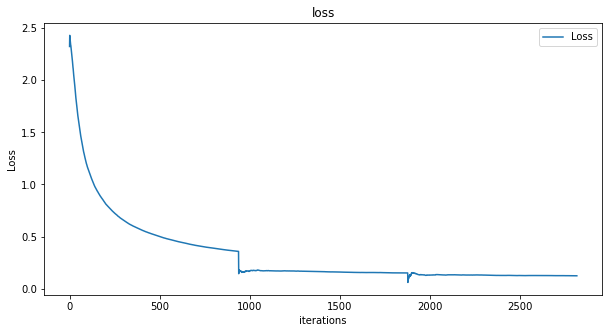

	Activate function : relu

Epoch:1
	Batch:938 of 938, loss:0.057, MeanLoss:0.387
	Accuracy of the network on the 10000 test images: 96.370 %

Epoch:2
	Batch:938 of 938, loss:0.167, MeanLoss:0.161
	Accuracy of the network on the 10000 test images: 97.570 %

Epoch:3
	Batch:938 of 938, loss:0.094, MeanLoss:0.129
	Accuracy of the network on the 10000 test images: 97.810 %
	Total_time : 33.19501233100891


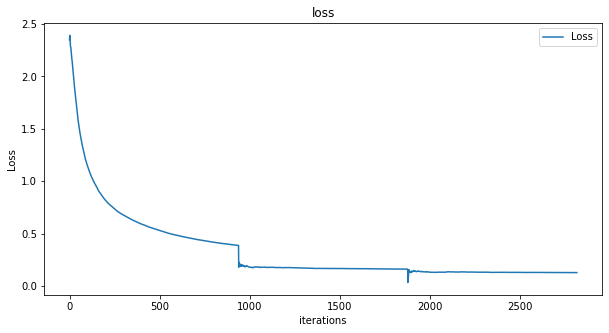

	Activate function : leaky_r

Epoch:1
	Batch:938 of 938, loss:0.354, MeanLoss:0.372
	Accuracy of the network on the 10000 test images: 96.340 %

Epoch:2
	Batch:938 of 938, loss:0.070, MeanLoss:0.162
	Accuracy of the network on the 10000 test images: 97.500 %

Epoch:3
	Batch:938 of 938, loss:0.045, MeanLoss:0.128
	Accuracy of the network on the 10000 test images: 97.820 %
	Total_time : 32.6793749332428


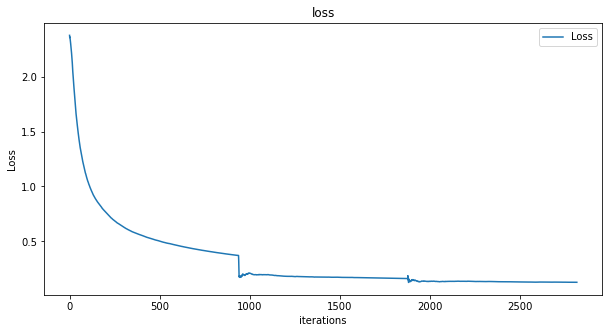

	Activate function : elu


In [53]:
for f in activate_f_list:
    net2 = choise_net(my_mnist_Net, f) #original model
    net2.apply(weights_reset)
    Optim = choise_optim(net2, 'sgd')

    train_part(net2, Mnist_trainloader, Mnist_testloader, CrossEntropy, Optim, 3, False)
    print(f'\tActivate function : {f}')

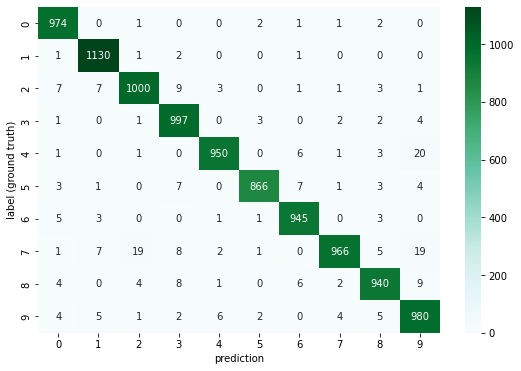

In [52]:
show_result(net2, Mnist_testloader, Mnist_classes)

## KMnist


Epoch:1
	Batch:938 of 938, loss:0.404, MeanLoss:0.642
	Accuracy of the network on the 10000 test images: 78.790 %

Epoch:2
	Batch:938 of 938, loss:0.094, MeanLoss:0.354
	Accuracy of the network on the 10000 test images: 84.040 %

Epoch:3
	Batch:938 of 938, loss:0.095, MeanLoss:0.289
	Accuracy of the network on the 10000 test images: 86.480 %

Epoch:4
	Batch:938 of 938, loss:0.387, MeanLoss:0.257
	Accuracy of the network on the 10000 test images: 87.680 %

Epoch:5
	Batch:938 of 938, loss:0.124, MeanLoss:0.234
	Accuracy of the network on the 10000 test images: 88.370 %

Epoch:6
	Batch:938 of 938, loss:0.081, MeanLoss:0.215
	Accuracy of the network on the 10000 test images: 89.230 %

Epoch:7
	Batch:938 of 938, loss:0.294, MeanLoss:0.204
	Accuracy of the network on the 10000 test images: 89.900 %
	Total_time : 76.11531400680542


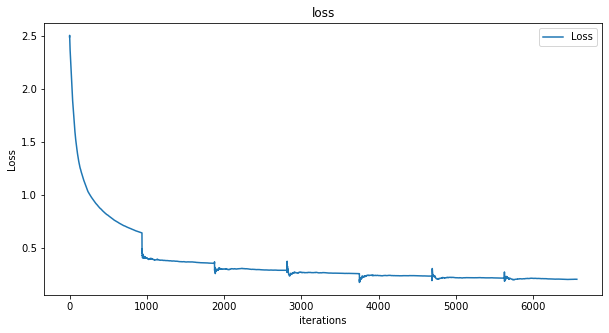

	Activate function : relu

Epoch:1
	Batch:938 of 938, loss:0.513, MeanLoss:0.633
	Accuracy of the network on the 10000 test images: 80.250 %

Epoch:2
	Batch:938 of 938, loss:0.304, MeanLoss:0.349
	Accuracy of the network on the 10000 test images: 83.850 %

Epoch:3
	Batch:938 of 938, loss:0.129, MeanLoss:0.291
	Accuracy of the network on the 10000 test images: 85.680 %

Epoch:4
	Batch:938 of 938, loss:0.136, MeanLoss:0.258
	Accuracy of the network on the 10000 test images: 86.970 %

Epoch:5
	Batch:938 of 938, loss:0.365, MeanLoss:0.239
	Accuracy of the network on the 10000 test images: 87.630 %

Epoch:6
	Batch:938 of 938, loss:0.118, MeanLoss:0.225
	Accuracy of the network on the 10000 test images: 88.480 %

Epoch:7
	Batch:938 of 938, loss:0.036, MeanLoss:0.211
	Accuracy of the network on the 10000 test images: 89.440 %
	Total_time : 78.1774308681488


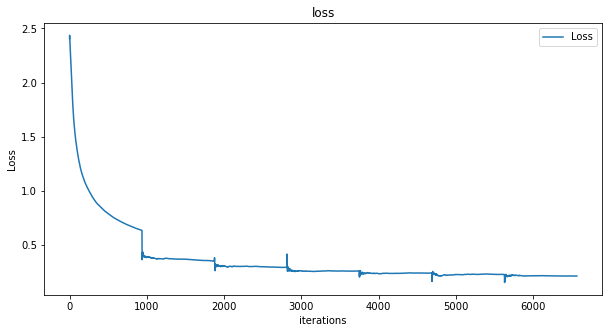

	Activate function : leaky_r

Epoch:1
	Batch:938 of 938, loss:0.329, MeanLoss:0.609
	Accuracy of the network on the 10000 test images: 79.740 %

Epoch:2
	Batch:938 of 938, loss:0.503, MeanLoss:0.343
	Accuracy of the network on the 10000 test images: 83.320 %

Epoch:3
	Batch:938 of 938, loss:0.168, MeanLoss:0.288
	Accuracy of the network on the 10000 test images: 85.640 %

Epoch:4
	Batch:938 of 938, loss:0.254, MeanLoss:0.257
	Accuracy of the network on the 10000 test images: 87.050 %

Epoch:5
	Batch:938 of 938, loss:0.117, MeanLoss:0.237
	Accuracy of the network on the 10000 test images: 87.590 %

Epoch:6
	Batch:938 of 938, loss:0.211, MeanLoss:0.219
	Accuracy of the network on the 10000 test images: 88.180 %

Epoch:7
	Batch:938 of 938, loss:0.276, MeanLoss:0.210
	Accuracy of the network on the 10000 test images: 88.900 %
	Total_time : 78.956622838974


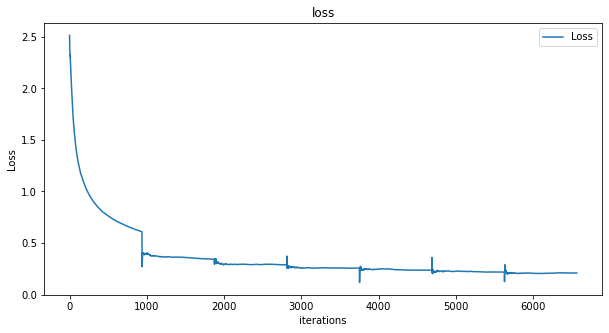

	Activate function : elu


In [50]:
for f in activate_f_list:
    net3 = choise_net(my_mnist_Net, f) #original model
    net3.apply(weights_reset)
    Optim = choise_optim(net3, 'sgd')

    train_part(net3, KMnist_trainloader, KMnist_testloader, CrossEntropy, Optim, 7, False)
    print(f'\tActivate function : {f}')

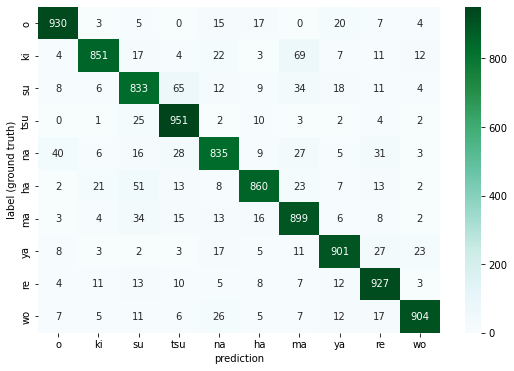

In [62]:
classes = ('o', 'ki', 'su', 'tsu', 'na', 'ha', 'ma', 'ya', 're', 'wo')
show_result(net3, KMnist_testloader, classes)

## ori


Epoch:1
	Batch:097 of 97, loss:4.279, MeanLoss:4.384
	Accuracy of the network on the 10000 test images: 2.255 %

Epoch:2
	Batch:097 of 97, loss:3.757, MeanLoss:3.944
	Accuracy of the network on the 10000 test images: 4.020 %

Epoch:3
	Batch:097 of 97, loss:3.891, MeanLoss:3.536
	Accuracy of the network on the 10000 test images: 7.353 %

Epoch:4
	Batch:097 of 97, loss:3.342, MeanLoss:3.221
	Accuracy of the network on the 10000 test images: 10.490 %

Epoch:5
	Batch:097 of 97, loss:3.207, MeanLoss:2.961
	Accuracy of the network on the 10000 test images: 6.373 %

Epoch:6
	Batch:097 of 97, loss:2.177, MeanLoss:2.728
	Accuracy of the network on the 10000 test images: 8.333 %

Epoch:7
	Batch:097 of 97, loss:2.776, MeanLoss:2.503
	Accuracy of the network on the 10000 test images: 8.333 %

Epoch:8
	Batch:097 of 97, loss:2.000, MeanLoss:2.345
	Accuracy of the network on the 10000 test images: 8.725 %

Epoch:9
	Batch:097 of 97, loss:2.012, MeanLoss:2.199
	Accuracy of the network on the 10000 tes

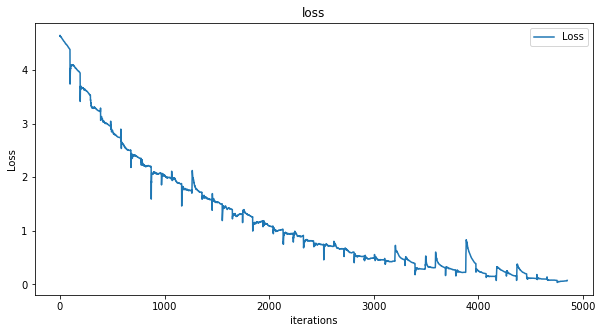

	Activate function : relu


In [25]:
for f in activate_f_list:
    net4 = choise_net(flower_Net, f) #original model
    net4.apply(weights_reset)
    Optim = choise_optim(net4, 'sgd')

    train_part(net4, flower_trainloader, flower_testloader, CrossEntropy, Optim, 50, False)
    print(f'\tActivate function : {f}')
    break

In [42]:
class_correct = list(0. for i in range(102))
class_total = list(0. for i in range(102))
print(class_total)
preds = np.zeros((1))
truth = np.zeros((1))
net4.eval()
with torch.no_grad():
    for data in flower_testloader:
        images, labels = data
        if minus1:
            labels -= 1
        outputs = net4(images.to(device))
        _, predicted = torch.max(outputs, 1)
        c = (predicted.cpu() == labels).squeeze()
        preds = np.concatenate([preds, predicted.cpu().numpy()], axis=0)
        truth = np.concatenate([truth, labels.numpy()], axis=0)
        for i in range(len(c)):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(102):
    print('Accuracy of %5s : %2d %%' % (
        flower_calsses[i], 100 * class_correct[i] / class_total[i]))

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Accuracy of pink primrose :  0 %
Accuracy of hard-leaved pocket orchid : 100 %
Accuracy of canterbury bells :  0 %
Accuracy of sweet pea : 12 %
Accuracy of english marigold : 50 %
Accuracy of tiger lily : 20 %
Accuracy of moon orchid : 16 %
Accuracy of bird of paradise : 50 %
Accuracy of monkshood : 10 %
Accuracy of globe thistle : 33 %
Accuracy of snapdragon :  0 %
Accuracy of colt's foot : 60 %
Accuracy of king protea : 33 %
Accuracy of spear thistle : 20 %
Accuracy of yellow iris :